https://www.kaggle.com/code/georgiosgiapitzakis/quantum-variational-classifier/notebook

In [2]:
# from qiskit_algorithms.optimizers import COBYLA
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator, Sampler
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import SPSA, COBYLA
from qiskit_machine_learning.algorithms.classifiers import VQC
import numpy as np
import pandas as pd

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [12]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [13]:
test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
# Replace female/male with 0/1
train['Sex'].replace(['female','male'], [0,1], inplace=True)
test['Sex'].replace(['female','male'], [0,1], inplace=True)

In [9]:
men, women = train.value_counts(subset=['Sex'])
print(f'No. of men onboard: {men}')
print(f'No. of women onboard: {women}')

No. of men onboard: 577
No. of women onboard: 314


In [14]:
survivors = train[train.Survived == 1]
men_perc = (survivors.Sex == 1).sum() / men * 100
women_perc = (survivors.Sex == 0).sum() / women * 100
print(f'Percentage of men that survived: {round(men_perc, 2)}%')
print(f'Percentage of women that survived: {round(women_perc, 2)}%')

Percentage of men that survived: 18.89%
Percentage of women that survived: 74.2%


In [17]:
train.corrwith(train["Survived"], numeric_only=True)

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Sex           -0.543351
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
dtype: float64

Extract training features

In [18]:
train_features = train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]
train_features.Age.fillna(train_features.Age.mean(), inplace=True)
train_features.Age = train_features.Age.astype(int)
train_labels = train['Survived']

normalize the values so everything falls in the range  
[0, 1]

In [19]:
from sklearn.preprocessing import MinMaxScaler

train_features = MinMaxScaler().fit_transform(train_features)

Load the data to the circuit

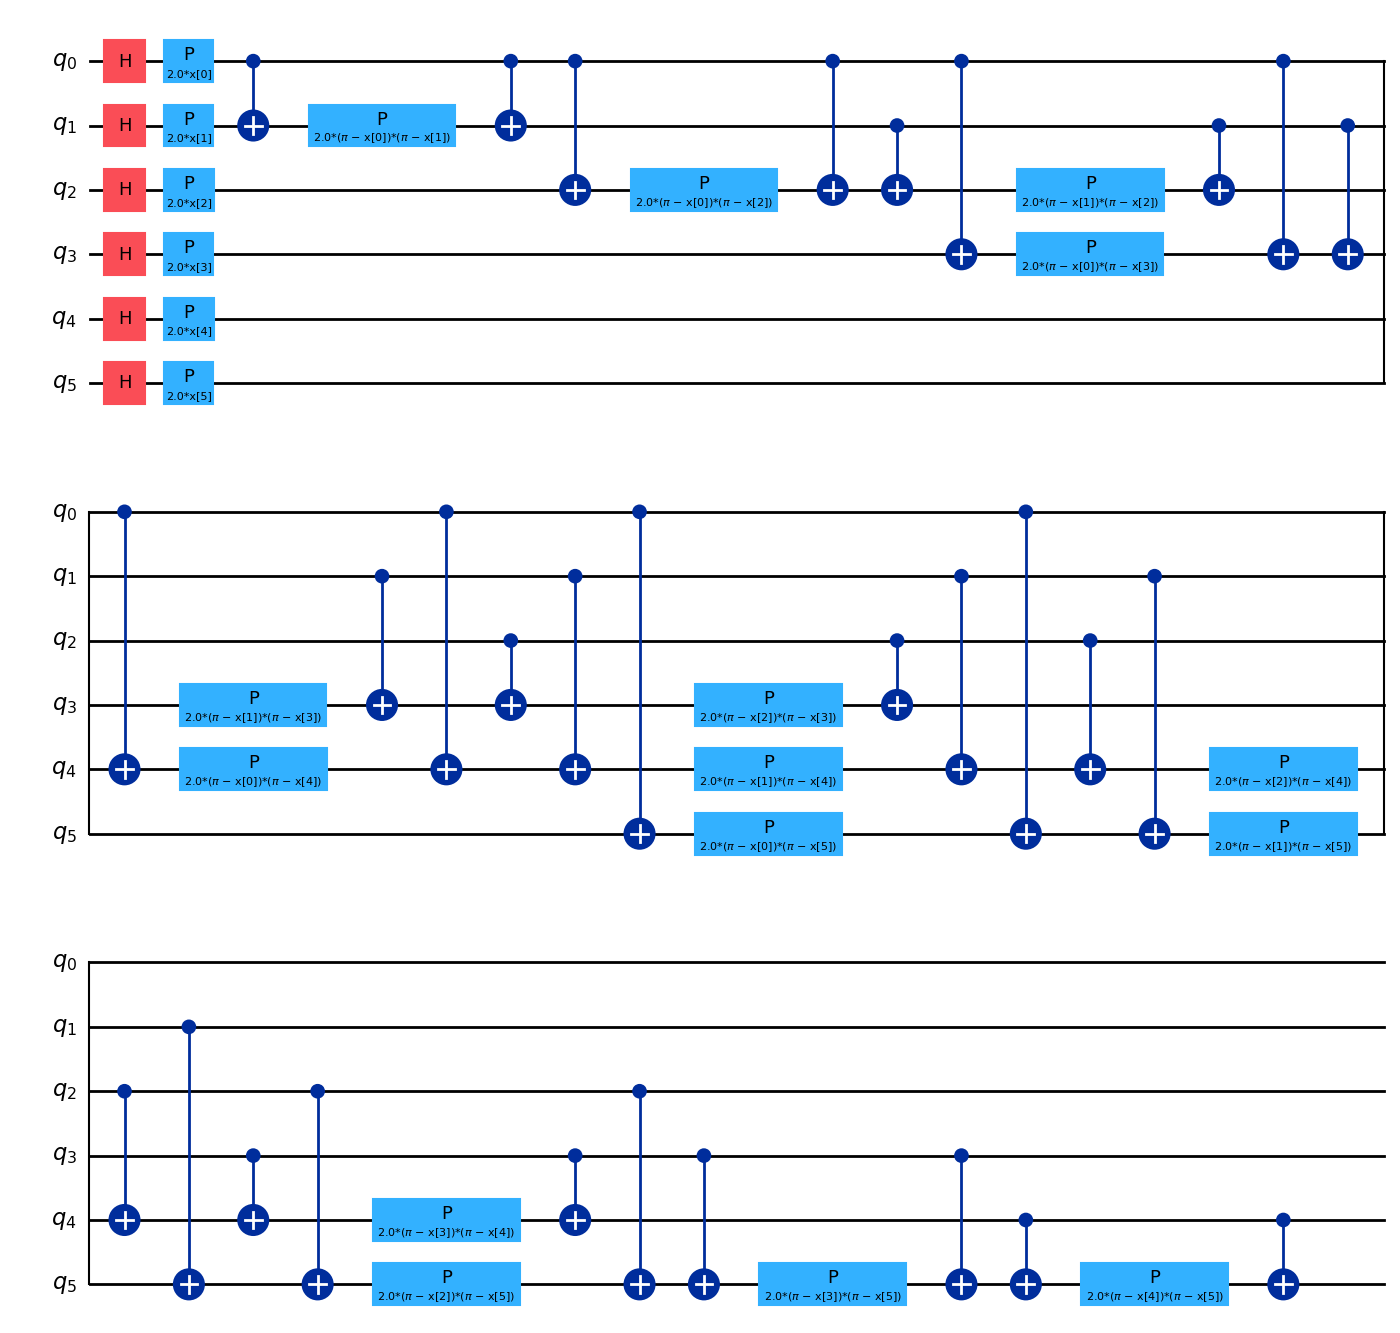

In [20]:
from qiskit.circuit.library import ZZFeatureMap

num_features = train_features.shape[1]
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)

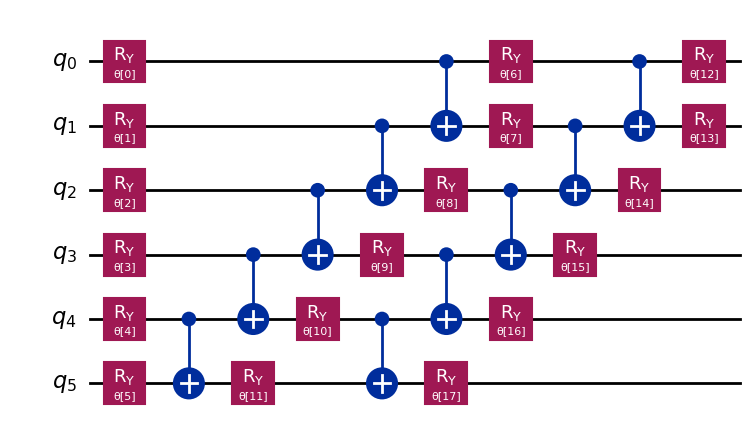

In [21]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=2)
ansatz.decompose().draw(output="mpl", fold=20)

Train the VQC

In [22]:
optimizer = COBYLA(maxiter=100)

In [24]:
from qiskit.primitives import Sampler

sampler = Sampler(options={"shots": 512})

In [25]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

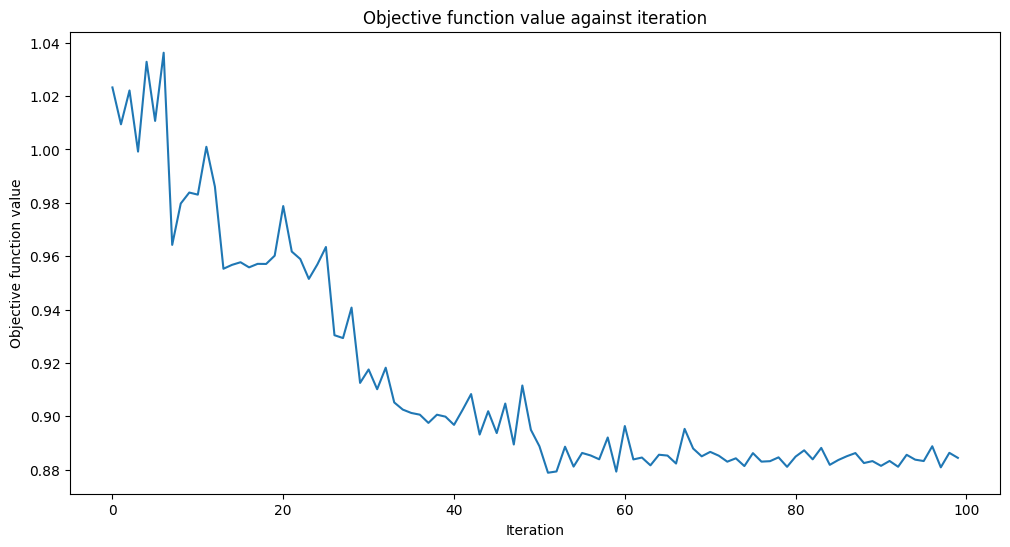

Training time: 718 seconds


In [26]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels.values)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [27]:
train_acc = vqc.score(train_features, train_labels)
print(f'Accuracy on the training data: {round(train_acc, 2) * 100}%')

Accuracy on the training data: 67.0%


Make predictions

In [28]:
test_features = test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]
test_features.Age.fillna(test_features.Age.mean(), inplace=True)
test_features.Age = test_features.Age.astype(int)
test_features.Fare.fillna(test_features.Fare.mean(), inplace=True)

In [29]:
test_features = MinMaxScaler().fit_transform(test_features)

In [30]:
y = vqc.predict(test_features)

In [31]:
output = pd.DataFrame({"PassengerId": test.PassengerId, "Survived": y})
output

,PassengerId,Survived
0,892,0
1,893,0
2,894,1
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
